# 4 - MRI imaging preprocessing

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Introduction

During this step we will preprocess MRI neuroimaging data, by keeping values related to subjects with DaTscan measures and those having all values available for the considered MRI features.

The analyzed MRI images were obtained from PPMI data portal and belonged to the subjects considered in our study.

We will also assess how the considered features describe the differences between PD patients and Healthy Controls (HCs), by computing the statistical significance of linear models:
 
$Y \sim s + eTIV + a + g$

where $Y$ is the imaging feature as predictor, $s$ the disease status (PD or HC), $eTIV$ the intercranial volume, $a$ the age of the subject, and $g$ the individual's gender.

To each linear model built using a different imaging feature, we assigned a *P*-value assessing how statistically significant could be the association of the considered feature to the disease in our dataset. The *P*-value computation is made in an R script called ```mriFeatureEvaluation.R```, which will be called via command line.

For further details on the linear models computation refer to ```mriFeatureEvaluation.R```.

In [2]:
patient_data_path = "../../data/patients_data/"
genotyping_path = "../../data/genotyping/"

## Selecting MRI features

In the previous step we focused on DATScan, which measures the changes in dopamine transporters uptake. 

As highlighted in (Ibarretxe-Bilbao, *et al.*, 2011), executive dysfunctions are frequently attributed to the dopamine loss in the striatum (caudate and putamen). Moreover, many studies showed structural changes in PD patients, correlating with motor dysfunctions (Nagano-Saito, *et al*., 2005; Camicioli, *et al.*, 2008; Ibarretxe-Bilbao, *et al.*, 2009).

Thus, we select those features related to executive dysfunctions identified in the previously mentioned works:

- parahippocampus (Nagano-Saito, *et al*., 2005)

- caudate and middle temporal gyri (Camicioli, *et al.*, 2008)

- lateral orbitofrontal cortex (Ibarretxe-Bilbao, *et al.*, 2009)

Let's now load the MRI measures.

In [3]:
ppmi_baseline_data = pd.read_csv(os.path.join(patient_data_path, "PPMI-baseline_data.csv"))
mri = ppmi_baseline_data.iloc[:,136:403]
mri["PATNO"] = ppmi_baseline_data.PATNO.tolist()
mri["EVENT_ID"] = ppmi_baseline_data.EVENT_ID.tolist()
mri["GENDER"] = ppmi_baseline_data.gen.tolist()
mri["Age"] = ppmi_baseline_data.age
cols = mri.columns.tolist()
cols = [cols[-4], cols[-3], cols[-2], cols[-1]] + cols[:-4]
mri = mri[cols]
mri.head()

,PATNO,EVENT_ID,GENDER,Age,eTIV,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,...,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox
0,3000,BL,2,69.1397,1.569770e+06,2409.0,2565.0,5700.0,3970.0,1928.0,...,232794.183113,457853.286475,228967.334429,230771.704186,459739.038614,54579.0,628301.286475,9.996803e+05,9.777723e+05,973296.0
1,3001,BL,1,65.1425,1.715151e+06,2801.0,1848.0,6032.0,3058.0,2674.0,...,245035.881750,485874.901257,266839.841075,271869.980507,538709.821583,65992.0,668025.901257,1.138365e+06,1.094811e+06,1092459.0
2,3002,BL,2,67.5781,1.356459e+06,2169.0,1154.0,5947.0,2745.0,2023.0,...,210527.029765,422545.400359,202130.549662,202273.312979,404403.862641,53588.0,585538.400359,9.026203e+05,8.838913e+05,881444.0
3,3003,BL,2,56.7178,1.577322e+06,2684.0,1240.0,6496.0,3388.0,3078.0,...,233175.330621,462961.509323,244307.778326,250607.214484,494914.992809,60128.0,636432.509323,1.040302e+06,1.020943e+06,1019030.0
4,3004,BL,1,59.4137,1.617682e+06,2845.0,2092.0,5010.0,2794.0,2410.0,...,240103.047784,479004.950904,258779.369008,260245.766111,519025.135119,55264.0,640446.950904,1.074093e+06,1.056334e+06,1053446.0


We can subset the DataFrame, in order to keep only the previously mentioned features of interest.

In [4]:
# features of interest
foi = [
    "PATNO",  # keep track of the subjects
    "EVENT_ID",  # keep track of the baseline visit
    "Age",  # used later
    "GENDER", # used later
    "eTIV",  # intercranial volume
    "lh_parahippocampal_volume",
    "rh_parahippocampal_volume",
    "lh_parahippocampal_thickness",
    "rh_parahippocampal_thickness", 
    "lh_parahippocampal_area",
    "rh_parahippocampal_area",
    "Left-Caudate",
    "Right-Caudate",
    "lh_middletemporal_volume",
    "rh_middletemporal_volume",
    "lh_middletemporal_thickness",
    "rh_middletemporal_thickness",
    "lh_middletemporal_area",
    "rh_middletemporal_area",
    "lh_lateralorbitofrontal_volume", 
    "rh_lateralorbitofrontal_volume", 
    "lh_lateralorbitofrontal_thickness",
    "rh_lateralorbitofrontal_thickness",
    "lh_lateralorbitofrontal_area",
    "rh_lateralorbitofrontal_area"
]

mri_foi = mri.loc[:, foi]
mri_foi.head(n=10)

,PATNO,EVENT_ID,Age,GENDER,eTIV,lh_parahippocampal_volume,rh_parahippocampal_volume,lh_parahippocampal_thickness,rh_parahippocampal_thickness,lh_parahippocampal_area,...,lh_middletemporal_thickness,rh_middletemporal_thickness,lh_middletemporal_area,rh_middletemporal_area,lh_lateralorbitofrontal_volume,rh_lateralorbitofrontal_volume,lh_lateralorbitofrontal_thickness,rh_lateralorbitofrontal_thickness,lh_lateralorbitofrontal_area,rh_lateralorbitofrontal_area
0,3000,BL,69.1397,2,1.569770e+06,2063.0,2392.0,2.656,2.940,680.0,...,2.417,2.647,3644.0,3472.0,7852.0,7631.0,2.565,2.539,2905.0,2881.0
1,3001,BL,65.1425,1,1.715151e+06,2129.0,2053.0,2.539,2.576,746.0,...,2.685,2.716,3906.0,4214.0,8380.0,8133.0,2.619,2.469,2924.0,3033.0
2,3002,BL,67.5781,2,1.356459e+06,1612.0,2233.0,2.801,3.086,503.0,...,2.933,2.590,2852.0,3711.0,7533.0,8313.0,2.681,2.675,2561.0,2879.0
3,3003,BL,56.7178,2,1.577322e+06,2294.0,1994.0,3.034,2.903,671.0,...,2.696,2.495,3766.0,4373.0,7887.0,8331.0,2.848,2.874,2610.0,2821.0
4,3004,BL,59.4137,1,1.617682e+06,2205.0,2127.0,2.885,2.819,696.0,...,2.558,2.687,3752.0,4002.0,8296.0,8046.0,2.566,2.458,2998.0,3118.0
5,3006,BL,57.5397,2,1.643901e+06,3134.0,2623.0,3.207,3.225,837.0,...,2.809,2.853,3659.0,4326.0,8121.0,8489.0,2.574,2.717,2959.0,2931.0
6,3007,BL,64.5479,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3008,BL,81.8904,2,1.281808e+06,1858.0,1923.0,2.978,2.858,521.0,...,2.202,2.283,2837.0,3604.0,6644.0,6514.0,2.369,2.540,2704.0,2463.0
8,3009,BL,83.6822,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3010,BL,46.9657,1,1.767759e+06,2126.0,2265.0,2.644,2.663,719.0,...,2.458,2.390,4709.0,5051.0,9206.0,8277.0,2.674,2.597,2974.0,2869.0


We still have data of subjects not considered in our study. So, let's retrieve data of those individuals.

In [5]:
ppmi_ceu_fam = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_merge_ceu_ds.fam"),
    sep="\s+",
    header=None
)

mri_foi_ceu = mri_foi[mri_foi.PATNO.isin(ppmi_ceu_fam.iloc[:,1].tolist())]
mri_foi_ceu = mri_foi_ceu.sort_values("PATNO").reset_index(drop=True)
mri_foi_ceu.head()

,PATNO,EVENT_ID,Age,GENDER,eTIV,lh_parahippocampal_volume,rh_parahippocampal_volume,lh_parahippocampal_thickness,rh_parahippocampal_thickness,lh_parahippocampal_area,...,lh_middletemporal_thickness,rh_middletemporal_thickness,lh_middletemporal_area,rh_middletemporal_area,lh_lateralorbitofrontal_volume,rh_lateralorbitofrontal_volume,lh_lateralorbitofrontal_thickness,rh_lateralorbitofrontal_thickness,lh_lateralorbitofrontal_area,rh_lateralorbitofrontal_area
0,3000,BL,69.1397,2,1.569770e+06,2063.0,2392.0,2.656,2.940,680.0,...,2.417,2.647,3644.0,3472.0,7852.0,7631.0,2.565,2.539,2905.0,2881.0
1,3001,BL,65.1425,1,1.715151e+06,2129.0,2053.0,2.539,2.576,746.0,...,2.685,2.716,3906.0,4214.0,8380.0,8133.0,2.619,2.469,2924.0,3033.0
2,3002,BL,67.5781,2,1.356459e+06,1612.0,2233.0,2.801,3.086,503.0,...,2.933,2.590,2852.0,3711.0,7533.0,8313.0,2.681,2.675,2561.0,2879.0
3,3004,BL,59.4137,1,1.617682e+06,2205.0,2127.0,2.885,2.819,696.0,...,2.558,2.687,3752.0,4002.0,8296.0,8046.0,2.566,2.458,2998.0,3118.0
4,3006,BL,57.5397,2,1.643901e+06,3134.0,2623.0,3.207,3.225,837.0,...,2.809,2.853,3659.0,4326.0,8121.0,8489.0,2.574,2.717,2959.0,2931.0


We can notice that 36 subjects have missing value for at least one of the considered features. We should remove them.

In [6]:
print(mri_foi_ceu.shape)
mri_foi_ceu = mri_foi_ceu.dropna()
print(mri_foi_ceu.shape)

(431, 25)
(395, 25)


In [7]:
mri_foi_ceu.head()

,PATNO,EVENT_ID,Age,GENDER,eTIV,lh_parahippocampal_volume,rh_parahippocampal_volume,lh_parahippocampal_thickness,rh_parahippocampal_thickness,lh_parahippocampal_area,...,lh_middletemporal_thickness,rh_middletemporal_thickness,lh_middletemporal_area,rh_middletemporal_area,lh_lateralorbitofrontal_volume,rh_lateralorbitofrontal_volume,lh_lateralorbitofrontal_thickness,rh_lateralorbitofrontal_thickness,lh_lateralorbitofrontal_area,rh_lateralorbitofrontal_area
0,3000,BL,69.1397,2,1.569770e+06,2063.0,2392.0,2.656,2.940,680.0,...,2.417,2.647,3644.0,3472.0,7852.0,7631.0,2.565,2.539,2905.0,2881.0
1,3001,BL,65.1425,1,1.715151e+06,2129.0,2053.0,2.539,2.576,746.0,...,2.685,2.716,3906.0,4214.0,8380.0,8133.0,2.619,2.469,2924.0,3033.0
2,3002,BL,67.5781,2,1.356459e+06,1612.0,2233.0,2.801,3.086,503.0,...,2.933,2.590,2852.0,3711.0,7533.0,8313.0,2.681,2.675,2561.0,2879.0
3,3004,BL,59.4137,1,1.617682e+06,2205.0,2127.0,2.885,2.819,696.0,...,2.558,2.687,3752.0,4002.0,8296.0,8046.0,2.566,2.458,2998.0,3118.0
4,3006,BL,57.5397,2,1.643901e+06,3134.0,2623.0,3.207,3.225,837.0,...,2.809,2.853,3659.0,4326.0,8121.0,8489.0,2.574,2.717,2959.0,2931.0


We remain with 395 subjects. Now, let's store their data in a CSV file called ```MRI_CEU.csv```.

In [8]:
mri_foi_ceu.to_csv(os.path.join(patient_data_path, "MRI_CEU.csv"), index=False)

Let's also keep consistency in genetyping data, by keeping only those subjects with complete MRI measures.

In [9]:
pd.DataFrame(
    zip(mri_foi_ceu.PATNO.tolist(), mri_foi_ceu.PATNO.tolist())
).to_csv(
    os.path.join(genotyping_path, "mrisubjs.txt"),
    sep=" ",
    index=False
)

!plink --bfile {os.path.join(genotyping_path, "PPMI_merge_ceu_ds")} --keep {os.path.join(genotyping_path, "mrisubjs.txt")} --make-bed --out {os.path.join(genotyping_path, "PPMI_merge_ceu_mri")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_ceu_mri.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu_ds
  --keep ../../data/genotyping/mrisubjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_ceu_mri

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
431 people (289 males, 142 females) loaded from .fam.
--keep: 395 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 395 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997815.
164548 variants and 395 

## Assessing statistical significance of MRI features

Now, we evaluate the statistical significance of discriminative power between HCs and PD patients of the considered features.

To accomplish this task, we call from command line the R script ```mriFeatureEvaluation.R```, which computes a linear model for each imaging feature (used as predictor of the PD presence) and assigns a *P*-value to each model, assessing how it is able to predict the category.

In [10]:
!Rscript mriFeatureEvaluation.R

Carico il pacchetto richiesto: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Carico il pacchetto richiesto: assertthat

Attaching package: ‘assertthat’

The following object is masked from ‘package:tibble’:

    has_name



The output produced by ```mriFeatureEvaluation.R``` is a CSV file, called ```mriFeaturesrank.csv``` storing the MRI imaging features sorted by statistical significance (*q*-values obtained correcting the *P*-values, with Benjamini-Hochberg procedure).

In [11]:
features = pd.read_csv(
    os.path.join(patient_data_path, "mriFeaturesRank.csv")
).sort_values(["p.adj", "p"]).reset_index(drop=True)
features

,Name,p,p.adj
0,rh_parahippocampal_volume,0.000107,0.002134
1,rh_parahippocampal_thickness,0.008163,0.064675
2,rh_parahippocampal_area,0.009701,0.064675
3,lh_parahippocampal_area,0.078904,0.349409
4,lh_parahippocampal_volume,0.087352,0.349409
5,Right.Caudate,0.151616,0.505388
6,Left.Caudate,0.338481,0.946436
7,lh_lateralorbitofrontal_area,0.422321,0.946436
8,lh_parahippocampal_thickness,0.429567,0.946436
9,rh_lateralorbitofrontal_volume,0.473218,0.946436


Parahippocampal (right side) features have good predictive power (*q*-value $< 0.1$). Therefore, in the following of our study we consider parahippocampal measures (right and left side).

Let's now explore how parahippocampal values distribute.

In [12]:
mri_parahippo = mri_foi_ceu[
    [
        "PATNO",
        "EVENT_ID",
        "Age",
        "GENDER", 
        "eTIV",
        "lh_parahippocampal_volume",
        "rh_parahippocampal_volume",
        "lh_parahippocampal_thickness",
        "rh_parahippocampal_thickness", 
        "lh_parahippocampal_area",
        "rh_parahippocampal_area"
    ]
]
mri_parahippo.head()

,PATNO,EVENT_ID,Age,GENDER,eTIV,lh_parahippocampal_volume,rh_parahippocampal_volume,lh_parahippocampal_thickness,rh_parahippocampal_thickness,lh_parahippocampal_area,rh_parahippocampal_area
0,3000,BL,69.1397,2,1.569770e+06,2063.0,2392.0,2.656,2.940,680.0,723.0
1,3001,BL,65.1425,1,1.715151e+06,2129.0,2053.0,2.539,2.576,746.0,721.0
2,3002,BL,67.5781,2,1.356459e+06,1612.0,2233.0,2.801,3.086,503.0,606.0
3,3004,BL,59.4137,1,1.617682e+06,2205.0,2127.0,2.885,2.819,696.0,662.0
4,3006,BL,57.5397,2,1.643901e+06,3134.0,2623.0,3.207,3.225,837.0,693.0


In [13]:
# add enrolment cathegory
ppmi_ceu_mri = ppmi_baseline_data[ppmi_baseline_data.PATNO.isin(mri_foi_ceu.PATNO.tolist())].reset_index(drop=True)
ppmi_ceu_mri.sort_values("PATNO", ascending=True)
mri_parahippo["ENROLL_CAT"] = ppmi_ceu_mri.ENROLL_CAT.tolist()
mri_parahippo.head()

/Users/manuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,PATNO,EVENT_ID,Age,GENDER,eTIV,lh_parahippocampal_volume,rh_parahippocampal_volume,lh_parahippocampal_thickness,rh_parahippocampal_thickness,lh_parahippocampal_area,rh_parahippocampal_area,ENROLL_CAT
0,3000,BL,69.1397,2,1.569770e+06,2063.0,2392.0,2.656,2.940,680.0,723.0,HC
1,3001,BL,65.1425,1,1.715151e+06,2129.0,2053.0,2.539,2.576,746.0,721.0,PD
2,3002,BL,67.5781,2,1.356459e+06,1612.0,2233.0,2.801,3.086,503.0,606.0,PD
3,3004,BL,59.4137,1,1.617682e+06,2205.0,2127.0,2.885,2.819,696.0,662.0,HC
4,3006,BL,57.5397,2,1.643901e+06,3134.0,2623.0,3.207,3.225,837.0,693.0,PD


## MRI data normalization

*---- Description ----*

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


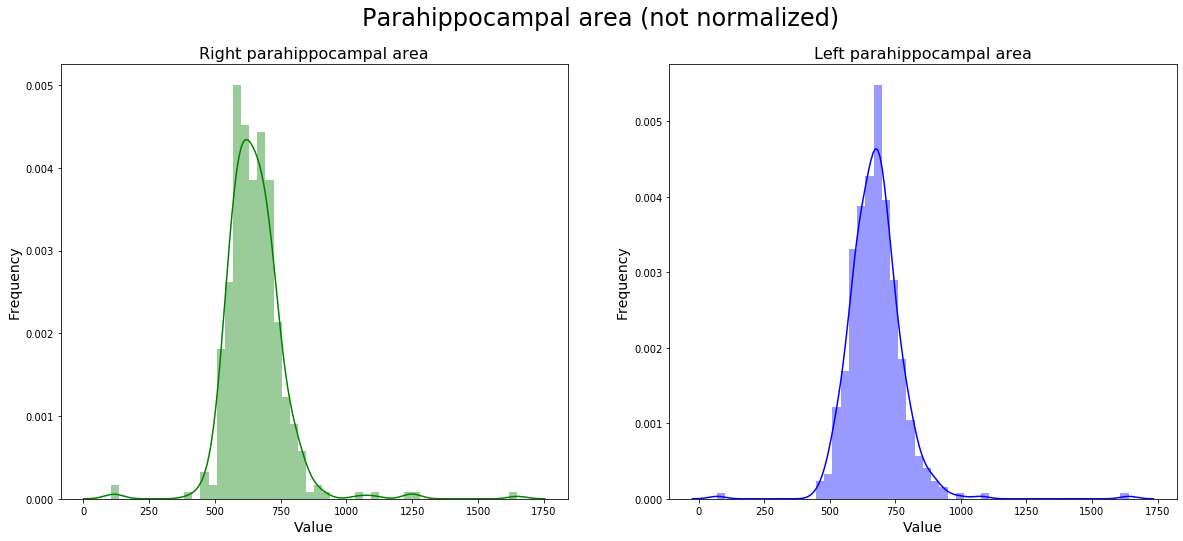

In [14]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo.rh_parahippocampal_area, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal area", size=16)
sns.distplot(mri_parahippo.lh_parahippocampal_area, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal area", size=16)
plt.suptitle("Parahippocampal area (not normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


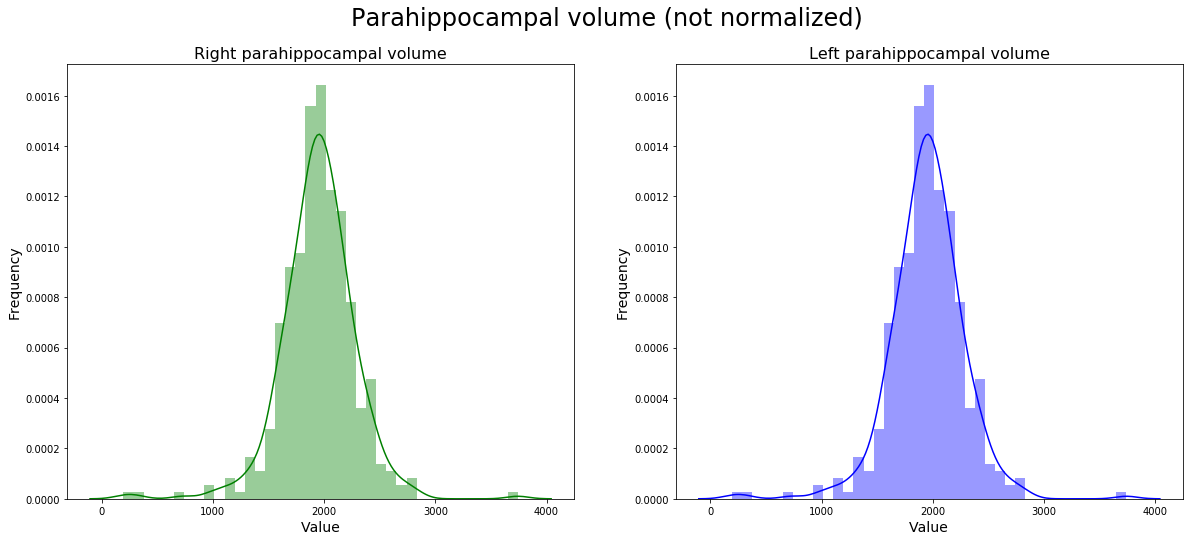

In [15]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo.rh_parahippocampal_volume, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal volume", size=16)
sns.distplot(mri_parahippo.rh_parahippocampal_volume, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal volume", size=16)
plt.suptitle("Parahippocampal volume (not normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


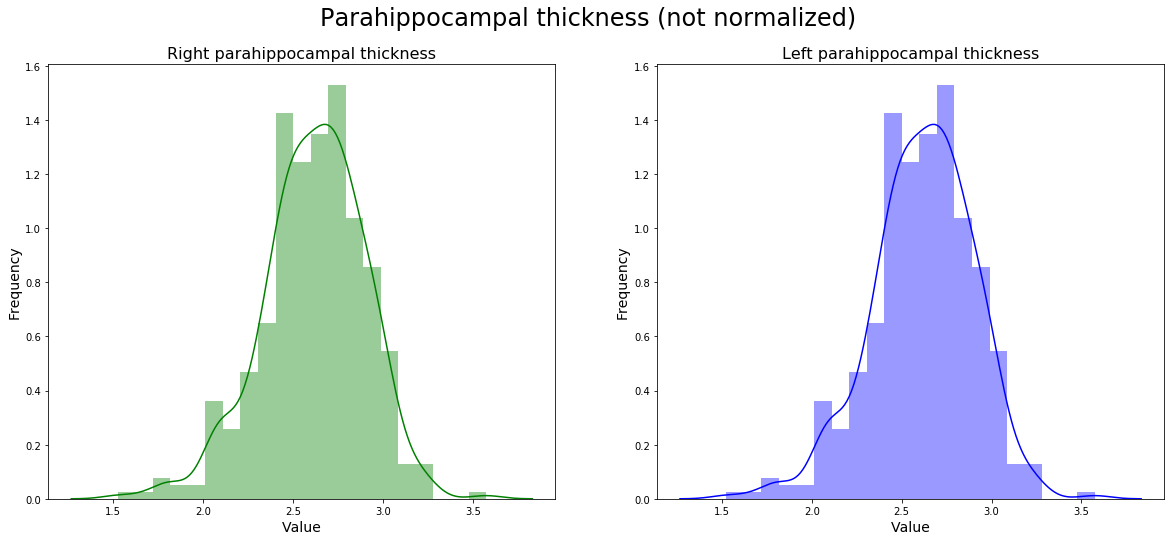

In [16]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo.rh_parahippocampal_thickness, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal thickness", size=16)
sns.distplot(mri_parahippo.rh_parahippocampal_thickness, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal thickness", size=16)
plt.suptitle("Parahippocampal thickness (not normalized)", size=24)
plt.show()

Clearly, all MRI parahippocampal morphological features are not normally distributed. The presence of outlier values can lead to wrong SNP-trait associations during GWAS analysis. Therefore, we should normalize our data.

Let's store MRI parahippocampal data and then switch to R to carry out normalization step.

In [17]:
mri_parahippo.to_csv(
    os.path.join(patient_data_path, "MRI_parahippo.csv"),
    index=False
)

In [18]:
!Rscript mriNorm.R

Carico il pacchetto richiesto: RNOmni
Warning message:
package ‘RNOmni’ was built under R version 3.6.2 


In [19]:
mri_parahippo_norm = pd.read_csv(
    os.path.join(patient_data_path, "MRI_parahippo_norm.csv")
)

Let's now plot normalized data.

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


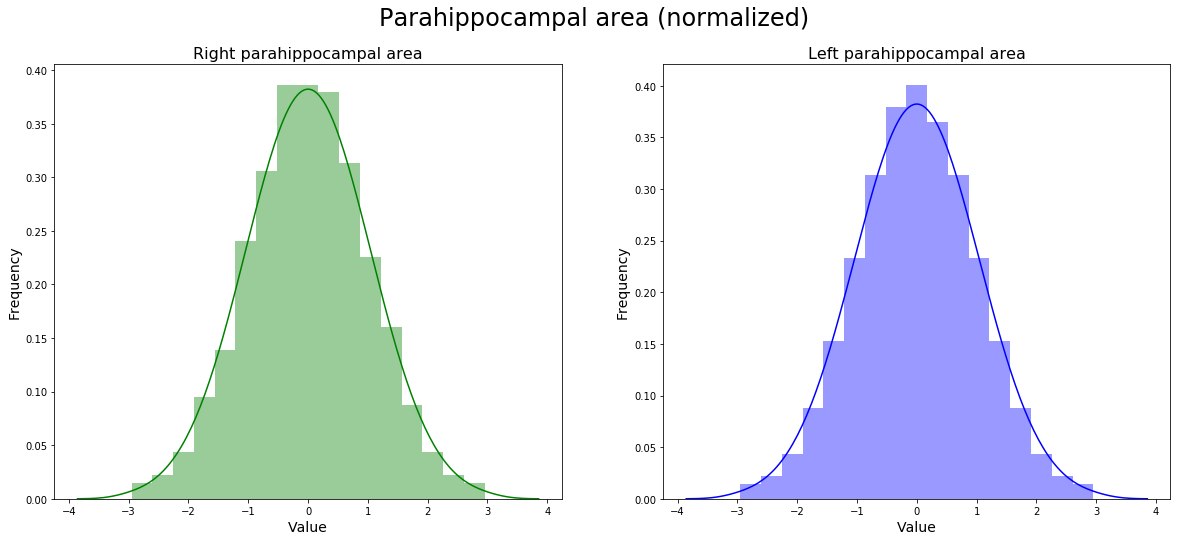

In [20]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo_norm.rh_parahippocampal_area, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal area", size=16)
sns.distplot(mri_parahippo_norm.lh_parahippocampal_area, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal area", size=16)
plt.suptitle("Parahippocampal area (normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


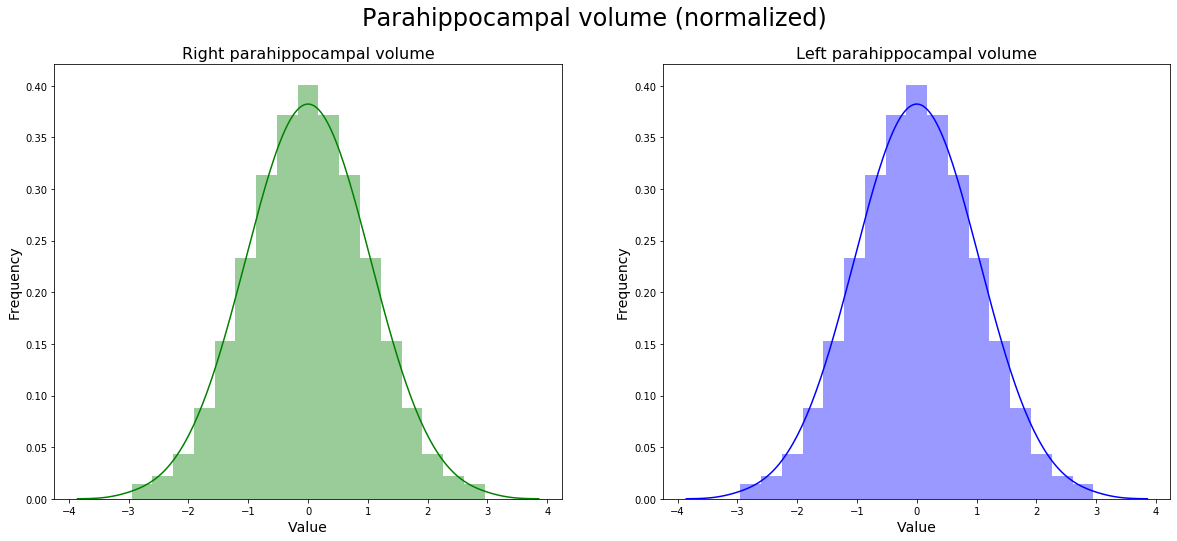

In [21]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo_norm.rh_parahippocampal_volume, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal volume", size=16)
sns.distplot(mri_parahippo_norm.rh_parahippocampal_volume, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal volume", size=16)
plt.suptitle("Parahippocampal volume (normalized)", size=24)
plt.show()

/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


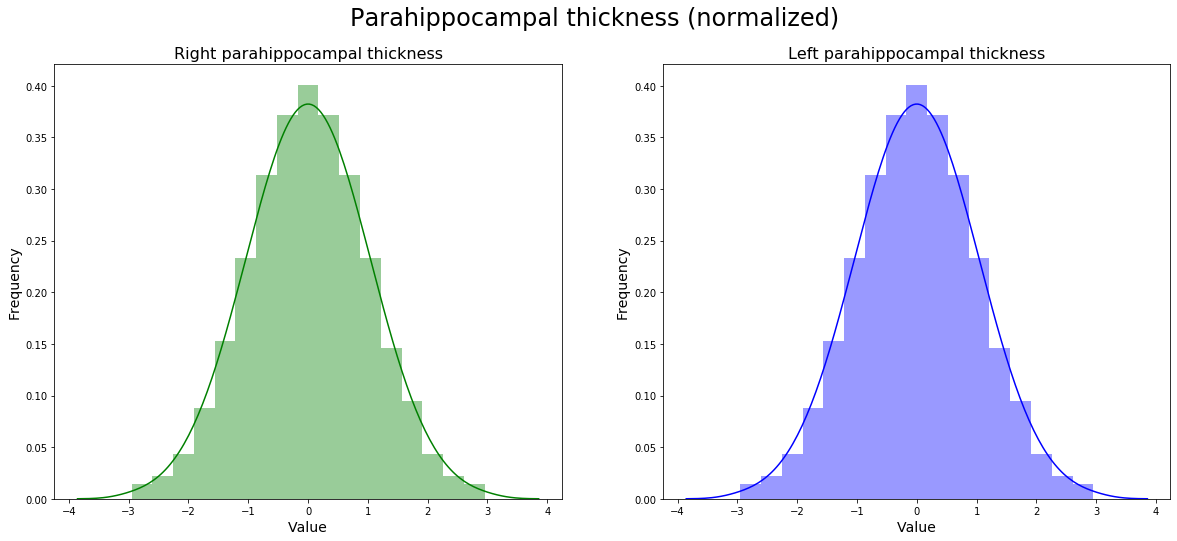

In [22]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.distplot(mri_parahippo_norm.rh_parahippocampal_thickness, hist=True, ax=axes[0], color="green")
axes[0].set_xlabel("Value", size=14)
axes[0].set_ylabel("Frequency", size=14)
axes[0].set_title("Right parahippocampal thickness", size=16)
sns.distplot(mri_parahippo_norm.rh_parahippocampal_thickness, hist=True, ax=axes[1], color="blue")
axes[1].set_xlabel("Value", size=14)
axes[1].set_ylabel("Frequency", size=14)
axes[1].set_title("Left parahippocampal thickness", size=16)
plt.suptitle("Parahippocampal thickness (normalized)", size=24)
plt.show()

Let's now explore how the MRI parahippocampal features are distributed among the Healthy controls and the PD patients.

In [23]:
ppmi_baseline_data_ceu = pd.read_csv(
    os.path.join(patient_data_path, "PPMI-baseline_ceu.csv")
)
ppmi_ceu_mri_fam = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_merge_ceu_mri.fam"),
    sep="\s+",
    header=None
)
ppmi_baseline_data_ceu = ppmi_baseline_data_ceu[ppmi_baseline_data_ceu.PATNO.isin(ppmi_ceu_mri_fam.iloc[:,1].tolist())].reset_index(drop=True)
ppmi_baseline_data_ceu["rh_parahippocampal_area_norm"] = mri_parahippo_norm.rh_parahippocampal_area.tolist()
ppmi_baseline_data_ceu["lh_parahippocampal_area_norm"] = mri_parahippo_norm.lh_parahippocampal_area.tolist()
ppmi_baseline_data_ceu["rh_parahippocampal_volume_norm"] = mri_parahippo_norm.rh_parahippocampal_volume.tolist()
ppmi_baseline_data_ceu["lh_parahippocampal_volume_norm"] = mri_parahippo_norm.lh_parahippocampal_volume.tolist()
ppmi_baseline_data_ceu["rh_parahippocampal_thickness_norm"] = mri_parahippo_norm.rh_parahippocampal_thickness.tolist()
ppmi_baseline_data_ceu["lh_parahippocampal_thickness_norm"] = mri_parahippo_norm.lh_parahippocampal_thickness.tolist()
ppmi_baseline_data_ceu.head()

,SITE,PATNO,APPRDX,EVENT_ID,age,age_cat,gen,EDUCYRS,educ,HISPLAT,...,CAUDATE_R_norm,CAUDATE_L_norm,PUTAMEN_R_norm,PUTAMEN_L_norm,rh_parahippocampal_area_norm,lh_parahippocampal_area_norm,rh_parahippocampal_volume_norm,lh_parahippocampal_volume_norm,rh_parahippocampal_thickness_norm,lh_parahippocampal_thickness_norm
0,10,3000,2,BL,69.1397,3,2,18,2,2,...,0.937686,1.365252,1.796193,1.459790,0.930121,0.120789,1.439867,-0.063461,1.198130,-0.136776
1,10,3001,1,BL,65.1425,2,1,16,2,2,...,-0.316156,-0.499551,-0.310052,-0.643345,0.882310,0.935019,0.366349,0.168859,-0.194650,-0.495151
2,10,3002,1,BL,67.5781,3,2,16,2,2,...,0.842657,1.643450,0.029066,0.697936,-0.431597,-2.068605,1.000873,-1.476592,1.889510,0.309271
3,10,3004,2,BL,59.4137,2,1,16,2,2,...,2.978297,2.978297,2.390802,1.891552,0.191419,0.352818,0.683975,0.424647,0.700090,0.594493
4,10,3006,1,BL,57.5397,2,2,14,2,2,...,0.040699,-0.181173,-0.402989,-2.507063,0.560773,1.756144,2.125762,2.476097,2.358624,1.786590


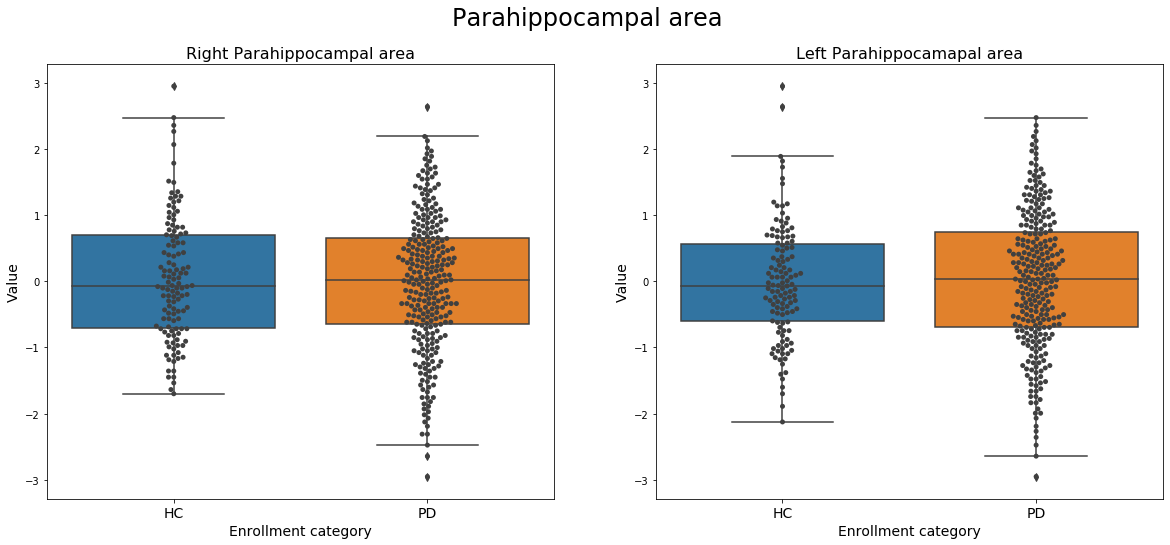

In [24]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(
    x="ENROLL_CAT",
    y="rh_parahippocampal_area_norm",
    data=ppmi_baseline_data_ceu,
    ax=axes[0]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "rh_parahippocampal_area_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[0]
)
axes[0].set_xlabel("Enrollment category", size=14)
axes[0].set_ylabel("Value", size=14)
axes[0].set_title("Right Parahippocampal area", size=16)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].set_xticks([0,1], ["HC", "PD"])
sns.boxplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_area_norm",
    data = ppmi_baseline_data_ceu,
    ax=axes[1]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_area_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[1]
)
axes[1].set_xlabel("Enrollment category", size=14)
axes[1].set_ylabel("Value", size=14)
axes[1].set_title("Left Parahippocamapal area", size=16)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].set_xticks([0,1], ["HC", "PD"])
plt.suptitle("Parahippocampal area", size=24)
plt.show()

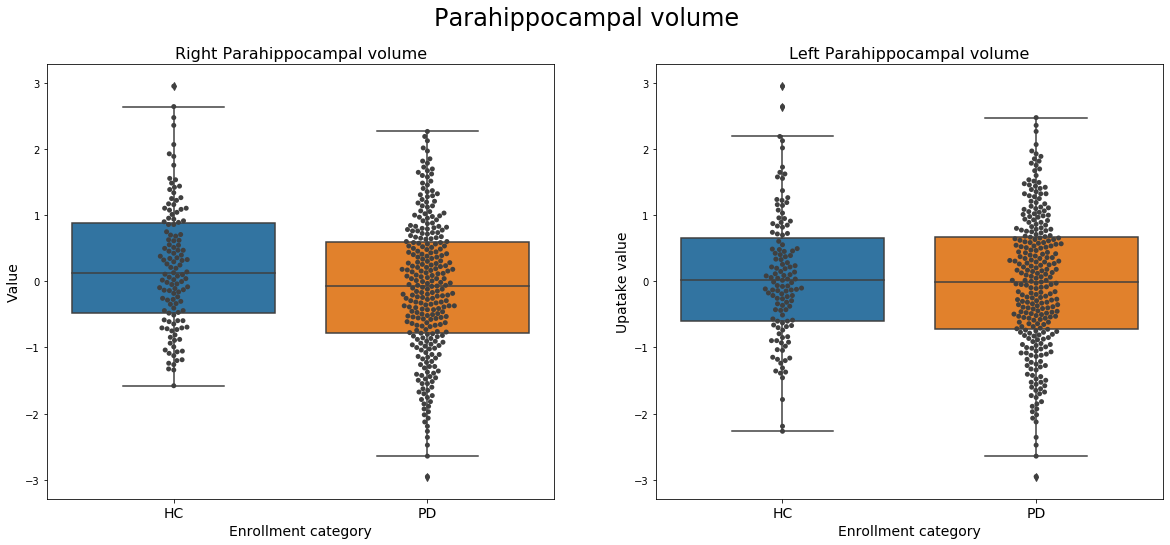

In [25]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(
    x="ENROLL_CAT",
    y="rh_parahippocampal_volume_norm",
    data=ppmi_baseline_data_ceu,
    ax=axes[0]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "rh_parahippocampal_volume_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[0]
)
axes[0].set_xlabel("Enrollment category", size=14)
axes[0].set_ylabel("Value", size=14)
axes[0].set_title("Right Parahippocampal volume", size=16)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].set_xticks([0,1], ["HC", "PD"])
sns.boxplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_volume_norm",
    data = ppmi_baseline_data_ceu,
    ax=axes[1]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_volume_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[1]
)
axes[1].set_xlabel("Enrollment category", size=14)
axes[1].set_ylabel("Upatake value", size=14)
axes[1].set_title("Left Parahippocampal volume", size=16)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].set_xticks([0,1], ["HC", "PD"])
plt.suptitle("Parahippocampal volume", size=24)
plt.show()

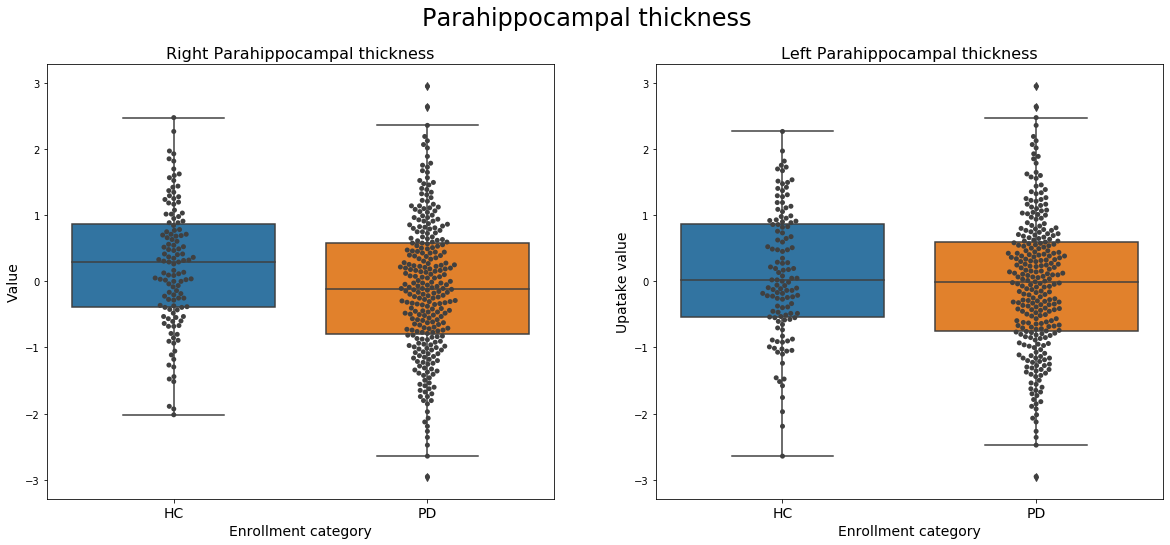

In [26]:
f, axes = plt.subplots(1,2, figsize=(20,8))
sns.boxplot(
    x="ENROLL_CAT",
    y="rh_parahippocampal_thickness_norm",
    data=ppmi_baseline_data_ceu,
    ax=axes[0]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "rh_parahippocampal_thickness_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[0]
)
axes[0].set_xlabel("Enrollment category", size=14)
axes[0].set_ylabel("Value", size=14)
axes[0].set_title("Right Parahippocampal thickness", size=16)
axes[0].xaxis.set_tick_params(labelsize=14)
axes[0].set_xticks([0,1], ["HC", "PD"])
sns.boxplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_thickness_norm",
    data = ppmi_baseline_data_ceu,
    ax=axes[1]
)
sns.swarmplot(
    x = "ENROLL_CAT",
    y = "lh_parahippocampal_thickness_norm",
    data = ppmi_baseline_data_ceu,
    color = ".25",
    ax=axes[1]
)
axes[1].set_xlabel("Enrollment category", size=14)
axes[1].set_ylabel("Upatake value", size=14)
axes[1].set_title("Left Parahippocampal thickness", size=16)
axes[1].xaxis.set_tick_params(labelsize=14)
axes[1].set_xticks([0,1], ["HC", "PD"])
plt.suptitle("Parahippocampal thickness", size=24)
plt.show()

Since during the final fucntional annotation and validation step of the workflow we will use RNA-se q data, we keep only those subjects having also transcriptomic data available on PPMI data portal.

These subjects IDs are stored in a TXT file named ```rnaseqsubjs.txt```.

In [27]:
rnaseqsubjs = pd.read_csv(
    os.path.join(genotyping_path, "rnaseqsubjs.txt"),
    sep=" ",
    header=None
)
ppmi_baseline_data_ceu = ppmi_baseline_data_ceu[ppmi_baseline_data_ceu.PATNO.isin(rnaseqsubjs.iloc[:,1].tolist())]
ppmi_baseline_data_ceu.to_csv(
    os.path.join(patient_data_path, "PPMI-baseline_CEU_final.csv"),
    index=False
)

We also subset the genotyping data in order to keep the previously extracted subjects.

In [28]:
!plink --bfile {os.path.join(genotyping_path, "PPMI_merge_ceu_mri")} --keep {os.path.join(genotyping_path, "rnaseqsubjs.txt")} --make-bed --out {os.path.join(genotyping_path, "PPMI_merge_final")} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_final.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_ceu_mri
  --keep ../../data/genotyping/rnaseqsubjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_final

16384 MB RAM detected; reserving 8192 MB for main workspace.
164548 variants loaded from .bim file.
395 people (261 males, 134 females) loaded from .fam.
--keep: 260 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 260 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997785.
164548 variants and 260 